<a href="https://colab.research.google.com/github/robindong3/SD2I/blob/main/SD2I_simulated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Down load the miniconda and astra toolbox



In [12]:
%env PYTHONPATH=

env: PYTHONPATH=


In [13]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-py39_23.3.1-0-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...



Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.


--2023-04-27 00:42:57--  https://repo.continuum.io/miniconda/Miniconda3-py39_23.3.1-0-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py39_23.3.1-0-Linux-x86_64.sh [following]
--2023-04-27 00:42:57--  https://repo.anaconda.com/miniconda/Miniconda3-py39_23.3.1-0-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70605094 (67M) [application/x-sh]
Saving to: ‘Miniconda3-py39_23.3.1-0-Linux-x86_64.sh.1’

     0K .......... .......... .......... .......... ..........  0% 4.55M 15s
    50K .......... .......... .

In [15]:
!conda --version
!which conda

conda 23.3.1
/usr/local/bin/conda


In [16]:
! conda install -c astra-toolbox/label/dev -y astra-toolbox

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

# All requested packages already installed.



In [18]:
import astra

ModuleNotFoundError: ignored

In [ ]:
! pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import all packages

In [ ]:
from nDTomo.sim.shapes.phantoms import SheppLogan
from nDTomo.utils.plots import showim
from nDTomo.ct.conv_tomo import fbpvol, sinocentering

from nDTomo.nn.models_tf import GANrec, SD2I, Automap, Discriminator
from nDTomo.nn.utils_tf import tf_gpu_devices, ReduceLROnPlateau_custom
from nDTomo.nn.tomo_tf import tf_create_angles, tf_tomo_transf, tf_tomo_radon, tf_tomo_squeeze, tf_tomo_bp, tf_mask_circle
from nDTomo.nn.losses_tf import ssim_mae_loss, discriminator_loss
from nDTomo.utils.misc import cirmask

import tqdm as tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

import tensorflow as tf

/usr/local/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Check if Tensorflow will run on GPU



In [ ]:
tf_gpu_devices()

physical_devices = tf.config.list_physical_devices('GPU') 

print(physical_devices)

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Default GPU Device:/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Creating the image, sinogram, and mask.



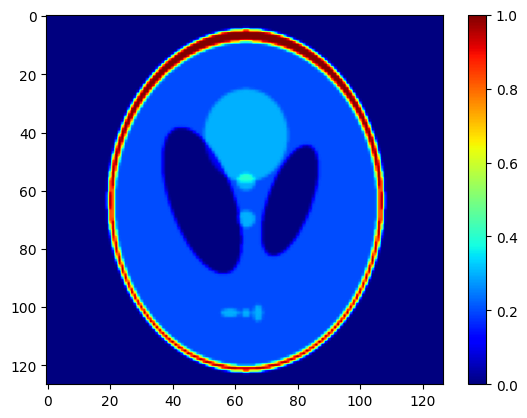

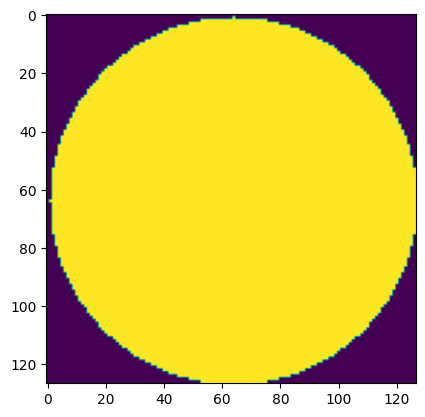

In [ ]:
npix = 128# image size
npr = 128 # number of projections
ang_samp = 4 # angular undersampling factor

npr = npr // ang_samp

with_disc = False # Use discriminator or not

method = 'SD2Iup' # Choose method from 'SD2Iup', 'SD2I', 'GANrec', 'Automap'

factor = 8 # Used for SD2I methods

nim = 1

im = SheppLogan(npix)

#forward to create a comparable result, npix should be odd. one line/coloum of empty array are removed from edge 
odd_correction = False
if npix % 2 == 0:
    pad = np.zeros_like(im)
    im = im[:-1,:-1]
    npix -= 1
    odd_correction = True

showim(im, 1, cmap = 'jet')

mask = np.ones((npix, npix))
mask = cirmask(mask,0)

mask = np.repeat(mask[:, :, np.newaxis], 1, axis=2)
plt.imshow(mask[:,:,0])

Doing Radon transformation on the simulated image

(1, 127, 127, 1)


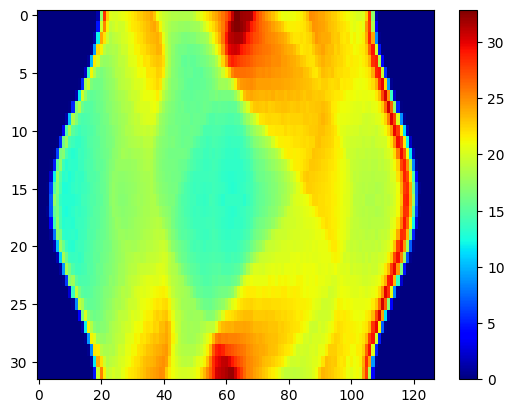

(1, 32, 127)


In [ ]:
data = im.reshape([npix,npix,1])

theta = tf_create_angles(npr)

imtf = tf_tomo_transf(im)
print(imtf.shape)

pattern_input = tf_tomo_radon(imtf, theta, interp_method='bilinear')
showim(tf_tomo_squeeze(pattern_input), 2)
pattern_input = pattern_input[:,:,:,0]

print(pattern_input.shape)

Calculate the reconstructed image using the filtered back projection algorithm

The dimensions of the reconstructed volume are  (127, 127)


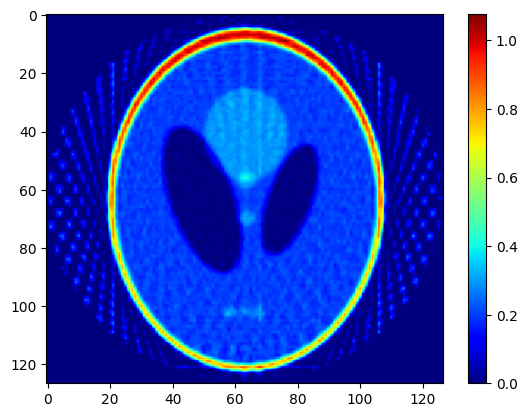

In [ ]:
fbp = fbpvol(np.array(pattern_input[0]).transpose(), theta=np.rad2deg(theta), nt = npix)
showim(fbp, 3, clim=(0, np.max(fbp)))

Next we prepare the function for training the neural network

Training loop

In [ ]:
if not with_disc:
    @tf.function 
    def train_step(input_number, dataset):
        print(1)
        with tf.GradientTape(persistent=True) as tape:

            generated_img = generator(input_number)
            generated_img = tf.math.abs(generated_img)

            print(generated_img.shape)

            pattern_gen = tf_tomo_radon(generated_img, theta)
            pattern_gen = pattern_gen[:,:,:,0]
            pattern_gen = tf.transpose(pattern_gen, [1, 2, 0])
            dataset = tf.transpose(dataset, [1, 2, 0])
            print(3)
            print(pattern_gen.shape)
            print(dataset.shape)

            matrix_loss = ssim_mae_loss(dataset, pattern_gen)

        grad_gen = tape.gradient(matrix_loss, generator.trainable_variables)

        gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
        return matrix_loss

else:
    @tf.function 
    def train_step(input_number, dataset):
        print(1)
        with tf.GradientTape(persistent=True) as tape:

            generated_img = generator(input_number)
            generated_img = tf.math.abs(generated_img)
            print(generated_img.shape)

            pattern_gen = tf_tomo_radon(generated_img, theta)
            
            real_output = discriminator(tf.expand_dims(dataset, -1))
            generated_output = discriminator(pattern_gen)
            
            pattern_gen = pattern_gen[:,:,:,0]
            pattern_gen = tf.transpose(pattern_gen, [1, 2, 0])
            dataset = tf.transpose(dataset, [1, 2, 0])
            print(2)
            print(dataset.shape)
            print(pattern_gen.shape)
            gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generated_output,
                                      labels=tf.ones_like(generated_output))) \
                       + ssim_mae_loss(dataset, pattern_gen)

            disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output, labels=tf.ones_like(real_output)))
            disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=generated_output, labels=tf.zeros_like(generated_output)))
            disc_loss = disc_loss_real+disc_loss_fake

        grad_disc = tape.gradient(disc_loss, discriminator.trainable_variables)
        grad_gen = tape.gradient(gen_loss, generator.trainable_variables)

        disc_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))
        gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
        print(3)
        return gen_loss


Setup the model, optimizers and learning rate



In [ ]:
if method == 'SD2Iup':
    generator = SD2I(npix, factor)
elif method == 'SD2I':
    generator = SD2I(npix, factor, upsample=False)
elif method == 'GANrec':
    generator = GANrec(npix)
elif method == 'Automap':
    generator = Automap(npix, npr)
    
if with_disc:
    discriminator = Discriminator(npix, npr)
    disc_optimizer = tf.keras.optimizers.Adam(0.0005)
    
generator.summary()
gen_optimizer = tf.keras.optimizers.Adam(0.0001)

reduce_rl_plateau = ReduceLROnPlateau_custom(patience=int(300/100),
                            factor=0.5,
                            verbose=1, 
                            optim_lr=gen_optimizer.learning_rate, 
                            reduce_lin=True)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 flatten (Flatten)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 8192)              532480    
                                                                 
 reshape (Reshape)           (None, 32, 32, 8)         0     

Setup the epochs needed and start the training loop.

In [ ]:
epochs = 8000
save_interval = 100

chemct_tf = tf.cast(pattern_input, 'float32')

if method == 'GANrec':
    bp = tf_tomo_bp(chemct_tf, theta)
    input_number = bp
elif method == 'Automap':
    input_number = chemct_tf
else:
    input_number = tf.cast(np.array([1]), 'float32')

start = time.time()
reduce_rl_plateau.on_train_begin()
kk = 1

for epoch in tqdm.tqdm_notebook(range(epochs)):

    loss = train_step(input_number, chemct_tf)

    if epoch % save_interval == 0 and epoch != 0:

        print('Time for epoch {} to {} is {} sec/it - gen_loss = {}'.format(epoch - save_interval + 1, epoch, (time.time() - start) / save_interval, loss))
        start = time.time()
        plt.close()

        reduce_rl_plateau.on_epoch_end(kk, loss)
        kk += 1


<ipython-input-13-5155521087ea>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(epochs)):


  0%|          | 0/8000 [00:00<?, ?it/s]

1
(1, 127, 127, 1)
3
(32, 127, 1)
(32, 127, 1)
1
(1, 127, 127, 1)
3
(32, 127, 1)
(32, 127, 1)
Time for epoch 1 to 100 is 0.14554985761642455 sec/it - gen_loss = 0.41664594411849976
Time for epoch 101 to 200 is 0.019932730197906492 sec/it - gen_loss = 0.2120022177696228
Time for epoch 201 to 300 is 0.017023162841796877 sec/it - gen_loss = 0.1430957168340683
Time for epoch 301 to 400 is 0.01829050064086914 sec/it - gen_loss = 0.09843739867210388
Time for epoch 401 to 500 is 0.014097402095794678 sec/it - gen_loss = 0.088028684258461
Time for epoch 501 to 600 is 0.01509711503982544 sec/it - gen_loss = 0.07743293046951294
Time for epoch 601 to 700 is 0.011507675647735596 sec/it - gen_loss = 0.068931944668293
Time for epoch 701 to 800 is 0.016500787734985353 sec/it - gen_loss = 0.057574886828660965
Time for epoch 801 to 900 is 0.018339672088623048 sec/it - gen_loss = 0.05868055671453476
Time for epoch 901 to 1000 is 0.014285471439361572 sec/it - gen_loss = 0.05571403354406357
Time for epoch 

Finally we plot the reconstructed image and compare it the filter back projected

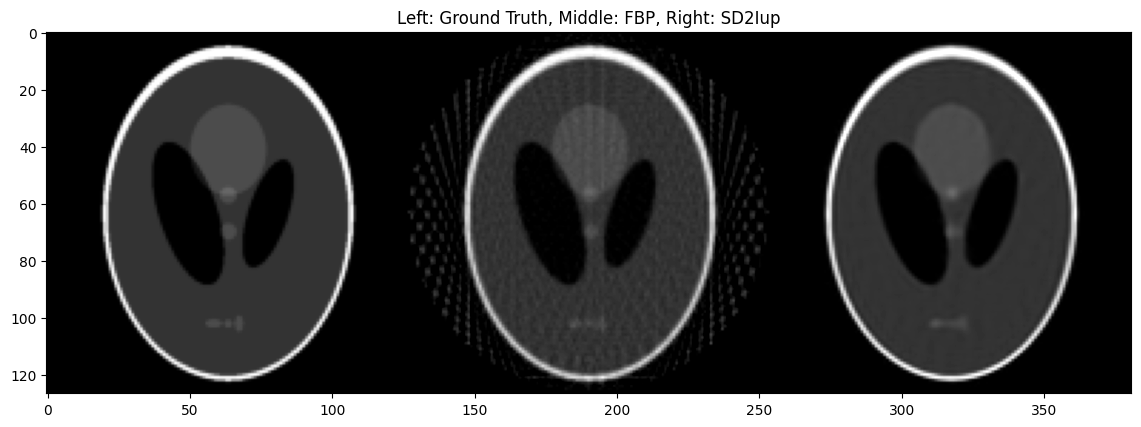

In [ ]:
generated_img = generator(input_number)
generated_img = np.array(generated_img)
generated_img[generated_img<0] = 0
generated_img = generated_img[0,:,:,0] * mask[:,:,0]

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(np.concatenate((im, fbp, generated_img[:,:]), axis=1), cmap='gray')
plt.clim(0, 1)
plt.title('Left: Ground Truth, Middle: FBP, Right: {}'.format(method))
plt.show()

Do SIRT, SART, CGLS

In [ ]:
img = [generated_img,  fbp, im]
text = [str(method), 'FBP with angular_undersampling', 'ground truth']
# %%

import matplotlib.pyplot as plt
import time
from skimage.draw import random_shapes
import astra
from numpy import deg2rad, arange
#%%
def astra_rec_single(sino, theta=None, scanrange = '180', method='FBP_CUDA', filt='Ram-Lak', nits = None):
    
    '''
    2D ct reconstruction using the astra-toolbox
    1st dim in sinogram is translation steps, 2nd is projections
    Available astra-toolbox reconstruction algorithms:
    ART, SART, SIRT, CGLS, FBP
    SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA
    
    possible values for FilterType:
    none, ram-lak, shepp-logan, cosine, hamming, hann, tukey, lanczos,
    triangular, gaussian, barlett-hann, blackman, nuttall, blackman-harris,
    blackman-nuttall, flat-top, kaiser, parzen    
    '''
    
    npr = sino.shape[1] # Number of projections
    
    if theta is None:
        if scanrange == '180':
            theta = deg2rad(arange(0, 180, 180/npr))
        elif scanrange == '360':
            theta = deg2rad(arange(0, 360, 360/npr))
            
    # Create a basic square volume geometry
    vol_geom = astra.create_vol_geom(sino.shape[0], sino.shape[0])
    # Create a parallel beam geometry with 180 angles between 0 and pi, and image.shape[0] detector pixels of width 1.
    proj_geom = astra.create_proj_geom('parallel', 1.0, int(1.0*sino.shape[0]), theta)
    # Create a sinogram using the GPU.
    proj_id = astra.create_projector('strip',proj_geom,vol_geom)
    sinogram_id = astra.data2d.create('-sino', proj_geom, sino.transpose())
    
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)
    
    cfg = astra.astra_dict(method)
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = proj_id
    if method == 'FBP' or method == 'FBP_CUDA':
        cfg['option'] = { 'FilterType': filt }
    else:
        if method == 'SART' or method == 'SIRT' or method == 'SART_CUDA' or method == 'SIRT_CUDA' or method == 'ART' or method == 'CGLS':
            cfg['option']={}
            cfg['option']['MinConstraint'] = 0
        if nits is None:
            nits = 10 
    
    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    start=time.time()

    if method == 'FBP' or method == 'FBP_CUDA':
        rec = astra.algorithm.run(alg_id)
    else:
        rec = astra.algorithm.run(alg_id, nits)
    
    # Get the result
    
    rec = astra.data2d.get(rec_id)
    
    print((time.time()-start))
        
    astra.data2d.delete(sinogram_id)
    astra.projector.delete(proj_id)
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    
    return(rec)
# %%
# %%

method = ['SART_CUDA', 'CGLS_CUDA', 'SIRT_CUDA']

for i in method:
    rec = astra_rec_single(np.array(pattern_input[0,:,:]).transpose(), theta=None, scanrange = '180', method=i, filt='Ram-Lak', nits = 250)
    rec[rec<0] = 0
    img.append(rec)
    text.append(i)


0.08305978775024414
0.12344765663146973
0.11023759841918945


Finally calculate some metrics to compare the reconstructed images

In [ ]:
if odd_correction:
    full = np.zeros([npix+1, npix+1])
    full[:-1,:-1] = im
    full = tf.cast(full, tf.float32)
else:
    full = tf.cast(im, tf.float32)
maxpoint = np.max(full)

In [ ]:
print(full.shape)
j = 0
for i in img:
    print(i.shape)
    text_sub = text[j]
    j += 1
    im = np.reshape(i, (1, npix, npix,1))
    gt = np.reshape(full, (1, full.shape[0],  full.shape[1],1))
    
    gt = tf.cast(gt, tf.float32)
    if odd_correction:
        im_new = np.zeros([1, npix+1, npix+1, 1])
        im_new[:, :-1,:-1, :] = im
        im = im_new
        
        i_new = np.zeros([npix+1, npix+1])
        i_new[:-1,:-1] = i
        i = i_new
    
    i = tf.cast(i, tf.float32)
    im = tf.cast(im, tf.float32)
    mae = tf.reduce_mean(tf.keras.losses.MAE(i, full)).numpy()

    mse = tf.reduce_mean(tf.keras.losses.MSE(i, full)).numpy()

    psnr = tf.image.psnr(im, gt, maxpoint).numpy()

    ssim = tf.image.ssim(im, gt, maxpoint).numpy()
    print(text_sub)
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('SSIM: ', ssim)
    print('PSNR: ', psnr)
    print('--------------------------------------')


(128, 128)
(127, 127)
SD2Iup
MAE:  0.006581131
MSE:  0.0003901203
SSIM:  [0.98803794]
PSNR:  [34.088013]
--------------------------------------
(127, 127)
FBP with angular_undersampling
MAE:  0.03124261
MSE:  0.0032279026
SSIM:  [0.7119411]
PSNR:  [24.910795]
--------------------------------------
(127, 127)
ground truth
MAE:  0.0
MSE:  0.0
SSIM:  [1.]
PSNR:  [inf]
--------------------------------------
(127, 127)
SART_CUDA
MAE:  0.008909315
MSE:  0.00046153337
SSIM:  [0.9623502]
PSNR:  [33.357967]
--------------------------------------
(127, 127)
CGLS_CUDA
MAE:  0.02970549
MSE:  0.0031770342
SSIM:  [0.5920075]
PSNR:  [24.97978]
--------------------------------------
(127, 127)
SIRT_CUDA
MAE:  0.010322216
MSE:  0.0006537728
SSIM:  [0.9384551]
PSNR:  [31.84573]
--------------------------------------


0
1
2
3
4
5


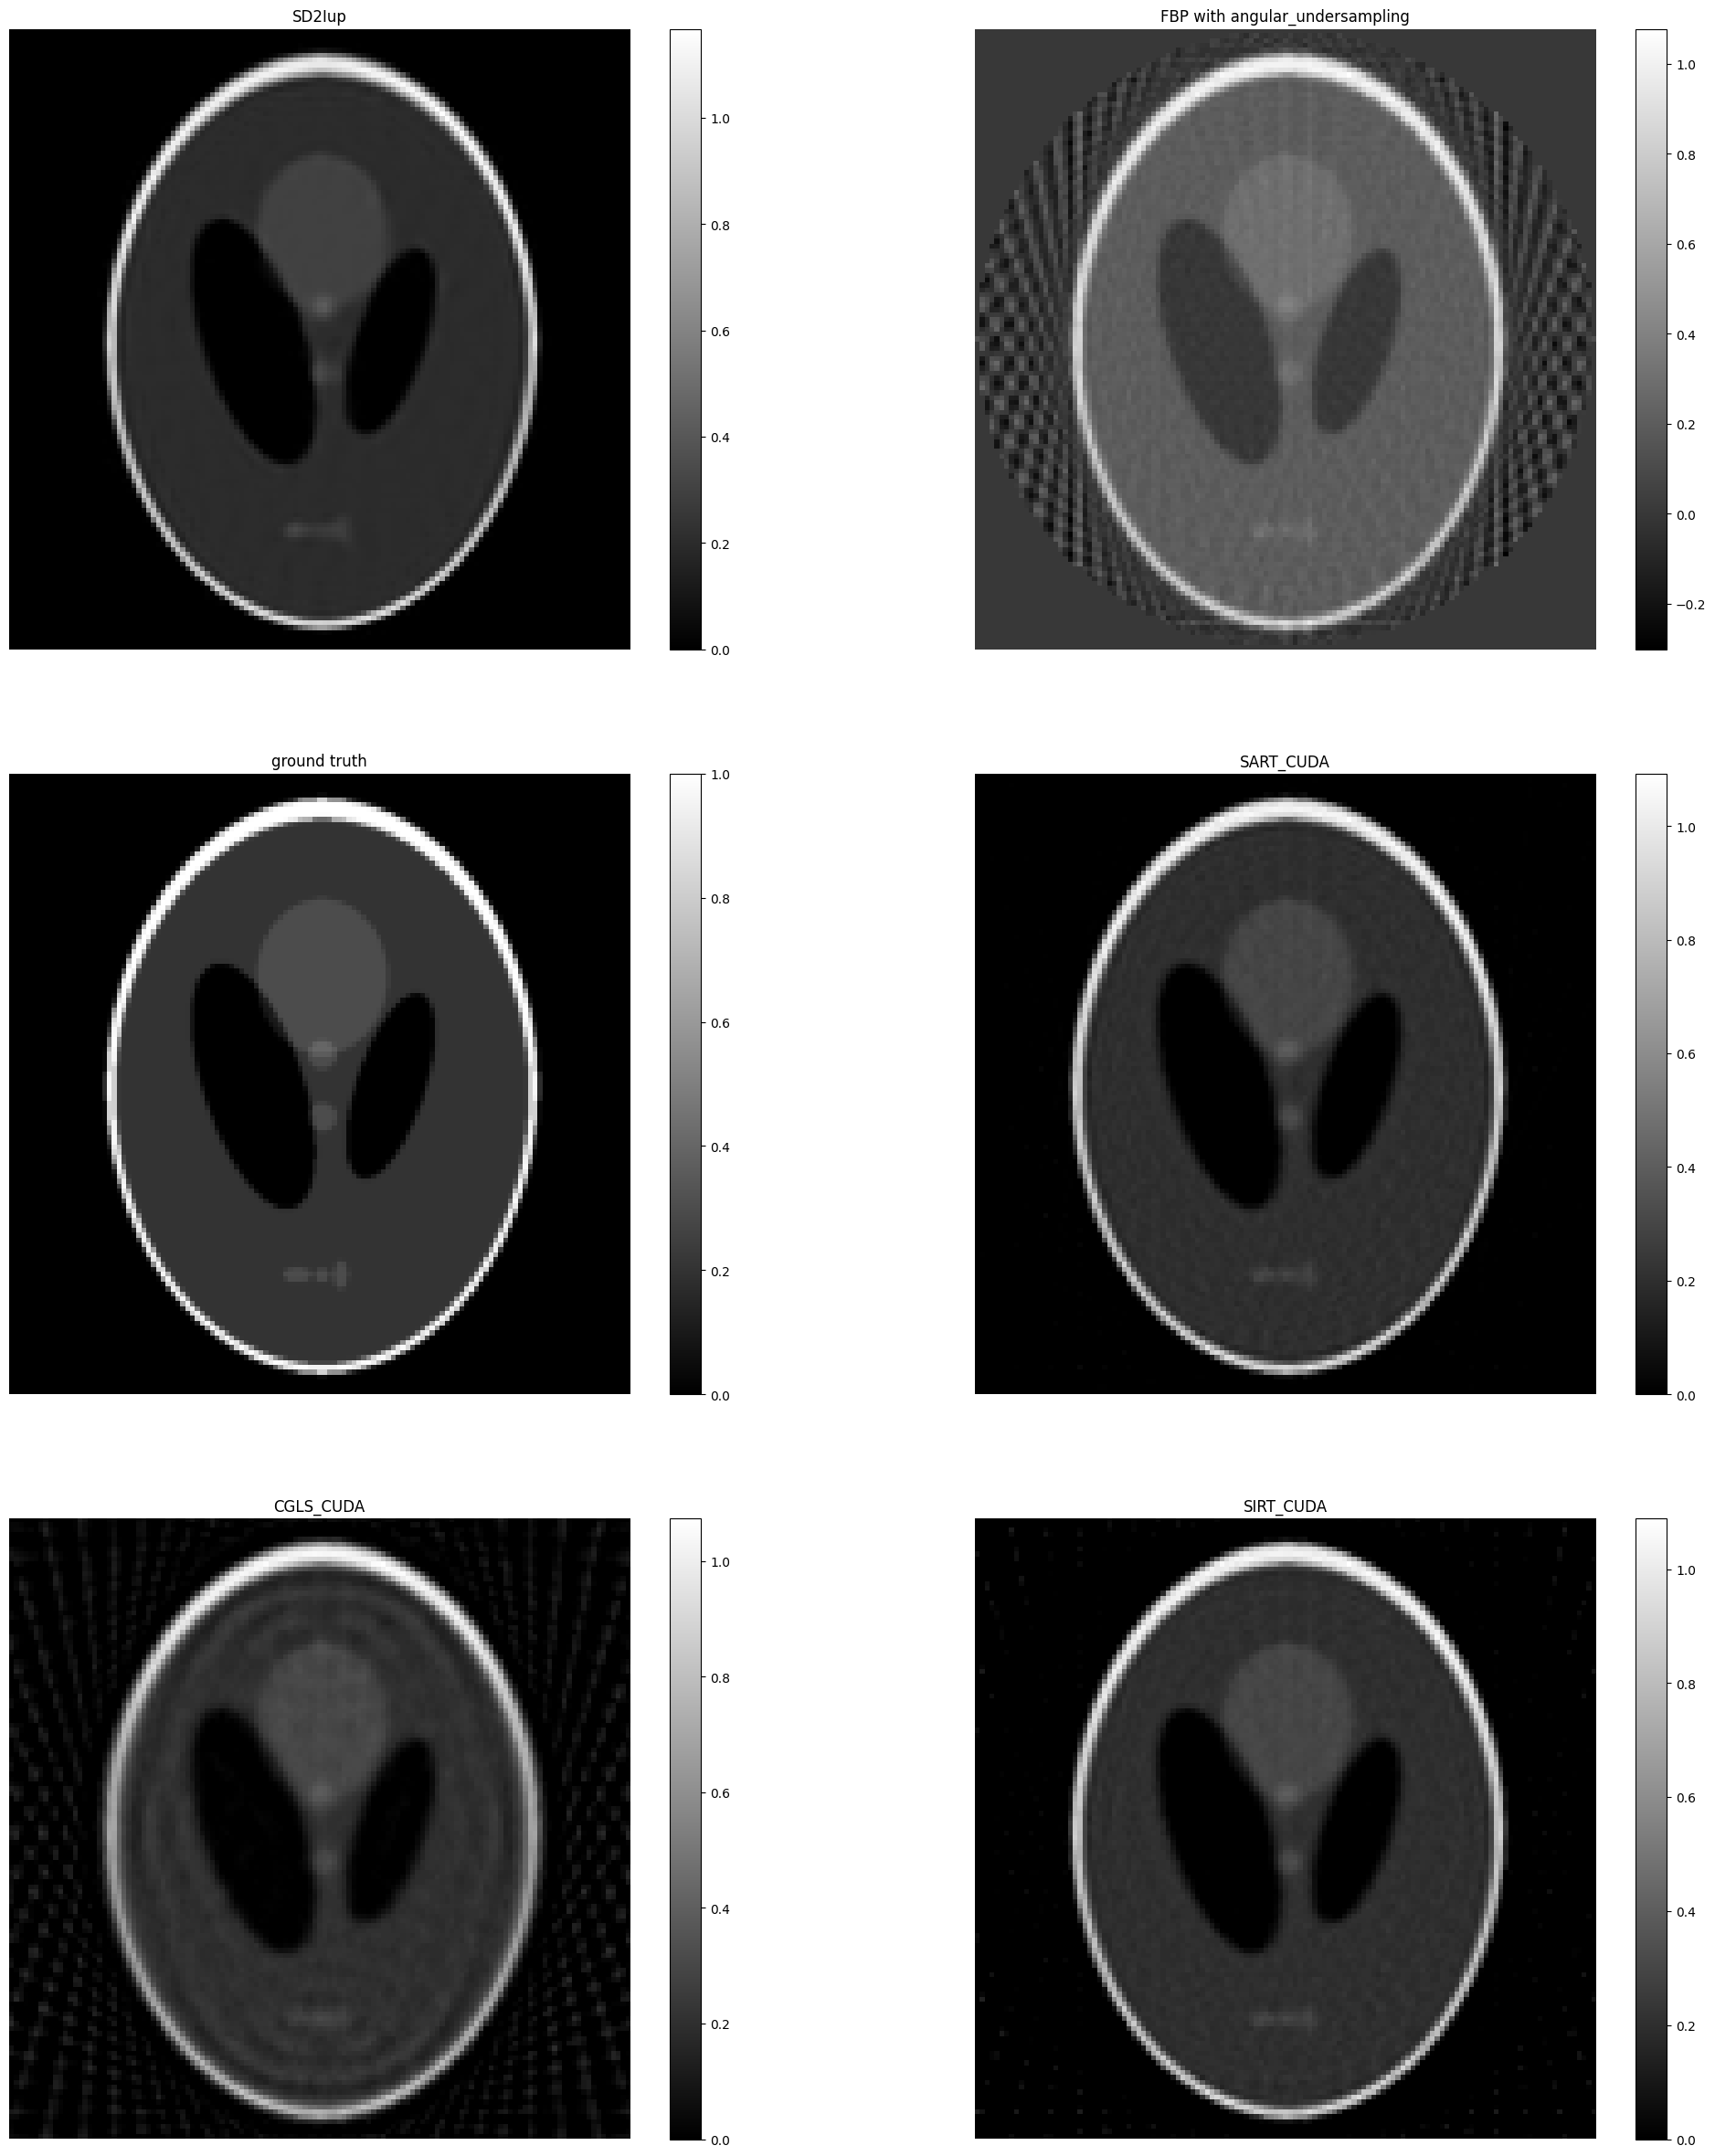

In [ ]:
def plotfigs_imgs(imagelist, legendlist, rows=1, cols=5, figsize=(20,3), cl=True, cmap = 'gray'):
    
    '''
    Create a collage of images without xticks/yticks
    
    @author: Antony Vamvakeros and Thanasis Giokaris
    '''
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
        
    kk = 0
    for ii in range(axes.shape[0]):
        for jj in range(axes.shape[1]):
        
            print(kk)
            
            if kk < len(imagelist):
                # if kk != len(imagelist) - 1:
                if 1 == 1:
                    # imagelist[kk][imagelist[kk]>0.1] = 0.1
                    # imagelist[kk][-1,-1] = 0.1
                    
                    # imagelist[kk][100:200,400:500][-1,-1] = maxpoint
                    # imagelist[kk][-1,-1] = maxpoint
                    # imagelist[kk][imagelist[kk]>40] = 40
                    # i = axes[ii,jj].imshow(imagelist[kk][100:200,400:500], cmap=cmap,interpolation='none')
                
                    i = axes[ii,jj].imshow(imagelist[kk], cmap=cmap,interpolation='none')
                    axes[ii,jj].set_axis_off()
                    axes[ii,jj].set_title(legendlist[kk])
                    # axes[ii,jj].clim(0,100)

                    if cl==True:
                        fig.colorbar(i, ax=axes[ii,jj])        
                    
                    kk = kk + 1
                else:
                    i = axes[ii,jj].imshow(imagelist[kk], cmap=cmap,interpolation='none')
                    axes[ii,jj].set_axis_off()
                    axes[ii,jj].set_title(legendlist[kk])
                
                    if cl==True:
                        fig.colorbar(i, ax=axes[ii,jj])        
                    

                    kk = kk + 1
    # fig.colorbar()
#     fig.savefig(folder + 'XRDCT_ch{}.png'.format(ch)).
plotfigs_imgs(img, text, rows=3, cols=2, figsize=(25,30), cl=True)
